This file is part of a program that is used to develop an objective way to
segment the fetus from ultrasound images, and to analyse the effectiveness of 
using the resulting mask to produce an unobstructed visualisation of the fetus.
The research is organised in three phases: (1) noise reduction filters, 
(2a) heuristic segmentation models, (2b) deep learning segmentation
approach (U-net), and (3) the volume visualisation. The program is developed
for the master Computational Science at the UvA from February to November 2020.

This file contains code for the deep learning segmentation approach (U-net). <br>
You can run this file to train and test the U-net network with ReLU activation functions and the original images as an input. <br>
The experiment analyses the effect of using different batch sizes in the same model. 

Made by Romy Meester


In [1]:
"""
Phase 2b: The deep learning segmentation approach (U-net).
- Input image: original image 
- Activation function: ReLU
"""

import os
import numpy as np
import pydicom
import pickle
import SimpleITK as sitk
import random 
import time
from tqdm import tqdm
import matplotlib.pyplot as plt
from jupyterthemes import jtplot

In [2]:
jtplot.style(context='paper', fscale=1.6, ticks=True, grid=False)

In [3]:
# Constants
DATA_PATH = '../datasets/'
RESULTS_PATH = 'results_unet_experiment'
RESULTS_MODEL_PATH = os.path.join(RESULTS_PATH, 'results_unet_model') 
RESULTS_DATA_PATH = os.path.join(RESULTS_PATH, 'results_unet_data')
RESULTS_IMG_PATH = os.path.join(RESULTS_PATH, 'results_unet_img')
RESULTS_VIS_PATH = os.path.join(RESULTS_PATH, 'results_unet_visualisations')

In [4]:
def create_folder(PATH):
    """ Create a folder. """
    try:
        os.mkdir(PATH)
        print('Directory', PATH, 'created' )
    except FileExistsError:
        print('Directory', PATH, 'already exists' )

# create results folder
create_folder(RESULTS_PATH)
    
# create results folder for saving the weights of the model 
create_folder(RESULTS_MODEL_PATH)

# create results folder for saving the frames, metadata, and metrics of the model 
create_folder(RESULTS_DATA_PATH)

# create results folder for the images (slices)
create_folder(RESULTS_IMG_PATH)

# create results folder for the plot visualisations 
create_folder(RESULTS_VIS_PATH)

Directory results_unet_experiment already exists
Directory results_unet_experiment\results_unet_model already exists
Directory results_unet_experiment\results_unet_data already exists
Directory results_unet_experiment\results_unet_img already exists
Directory results_unet_experiment\results_unet_visualisations already exists


# Load US data

In [5]:
def get_pixels(scans):
    """ Get pixel values of the scans. """
    image = np.stack([s.pixel_array for s in scans])        
    return np.array(image)

def load_scans(path):
    """ Load the scans and return the pixel values. """
    get_files = os.listdir(path) 
    slices = [] 

    # get all the slices
    for i in get_files:
        if i.endswith(".dcm"):
            with open(path + i, 'r') as f:
                path_filename = path + i
                one_slice = pydicom.dcmread(path_filename) 
                slices.append(one_slice)

    # get all the pixel values of the scan slices
    try:
        images = get_pixels(slices)
    except: 
        images = np.array(0)
        print('Path file is empty.')
        
    # squeeze image when not in series
    images = images.squeeze()
    
    return images 

def get_data(rootdir, datasetnames):
    """ Generate the dataset which includes the cropped, original images and the 
    ground truth images of the datasets. The input is the root directory to the 
    folders with the corresponding dataset names. The output is a dictionary
    with all these images. 
    """
    datasets = {}

    print('Loading: ' + str(len(datasetnames)) + ' datasets')
    for dataset in tqdm(datasetnames):
        time.sleep(0.1)
        
        # generate the images 
        # Original images (to predict) and ground truth images (mask image of expert)
        images_org = load_scans(rootdir + dataset + '/crop_org/')
        images_gt = load_scans(rootdir + dataset + '/crop_gt/')

        # Save the images in datasets dictionary
        datasets.update({dataset : {'org': images_org, 'gt': images_gt}})

    print("datasets created")
    return datasets


In [6]:
folders = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]
datasets = get_data(DATA_PATH, folders)

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

Loading: 7 datasets


100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [02:00<00:00, 17.26s/it]

datasets created


# Image preprocessing

### Generate images in all directions

In [7]:
def generate_2Dslices(images_frames, images_masks):
    """ Generate the 2D slices in 3 different directions. 
        Input = 3D images
        Output = 2D images"""
    
    #check the datashapes
    if (images_frames.shape != images_masks.shape) and (images_masks != np.array(0)):
        print('The shapes of frames and masks are not the same')
    
    results_frames = []
    results_masks = []
    
    #generate the datasets in 3 different directions 
    for index, shape_size in enumerate(images_frames.shape):
        if index == 0:
            for n in range(shape_size):
                image_frame = images_frames[n,:,:]
                try:
                    image_mask = images_masks[n,:,:]
                except:
                    image_mask = None
                results_frames.append(image_frame)
                results_masks.append(image_mask)
        if index == 1: 
            for n in range(shape_size):
                image_frame = images_frames[:,n,:]
                try:
                    image_mask = images_masks[:,n,:]
                except:
                    image_mask = None
                results_frames.append(image_frame)
                results_masks.append(image_mask)
        if index == 2: 
            for n in range(shape_size):
                image_frame = images_frames[:,:,n]
                try:
                    image_mask = images_masks[:,:,n]
                except: 
                    image_mask = None #np.array(0)
                results_frames.append(image_frame)
                results_masks.append(image_mask)            
 
    return np.array(results_frames), np.array(results_masks)

def generate_dataset2D(inputdatasets):
    """ From the 3D images, generate the 2D dataset inside the dictionary dataset. """
    
    # iterate over inputdataset dictionary 
    # and make from all 3D images, 2D slices in the values
    for key, image_3D in inputdatasets.items(): 
        image_2D_frames, image_2D_masks = generate_2Dslices(image_3D['org'], image_3D['gt'])
        inputdatasets[key] = {'org': image_2D_frames, 'gt': image_2D_masks}
    

In [8]:
# copy dictionary datasets 
inputdatasets = datasets.copy()

# remake the images from 3D to 2D slices
generate_dataset2D(inputdatasets)

### Add padding to the images

In [9]:
def calc_processable_sizes(size): 
    """ Calculate sizes which can be processed in the U-net divisible by 32. """
    new_size = np.ceil(size / 32) * 32
    return int(new_size)

def get_sizes(datasets):
    """ Get the highest width and height of the images. """
    max_width = 0
    max_height = 0
    
    # get the heighest width and height from all images
    for key, images in datasets.items(): 
        org_images = images['org']
        for image in org_images:   
            h, w = image.shape[:2]
            max_width = max(max_width, w)
            max_height = max(max_height, h)

    # get the (bigger) closest widht and height divisible by 32
    print('heighest width and height of images:', max_width, max_height)
    max_width = calc_processable_sizes(max_width)
    max_height = calc_processable_sizes(max_height)

    print('final (w,h)', max_width,max_height)
    return max_width, max_height

def pad(image, max_height, max_width):
    """ Pad the images with zeros. """
    
    h, w = image.shape[:2]
    diff_vert = max_height - h
    pad_top = diff_vert // 2
    pad_bottom = diff_vert - pad_top
    diff_hori = max_width - w
    pad_left = diff_hori // 2
    pad_right = diff_hori - pad_left

    return np.copy(np.pad(image, ((pad_top, pad_bottom), (pad_left, pad_right)), mode='constant', constant_values=0))

    
def add_padding(images, size): 
    """ Add the padding. """
    max_width = size[0] 
    max_height = size[1]
    
    new_images = []
    
    for image in images: 
        new_image = pad(image, max_height, max_width)
        new_images.append(new_image)
        
    return np.array(new_images)

def transform_images(datasets):
    """ Add padding to the datasets to make all images the same size. """

    # get the biggest sizes
    size = get_sizes(datasets)
    
    # create padding around the images 
    for key, images in datasets.items(): 
        org_images = images['org']
        gt_images = images['gt']
        
        new_org_images = add_padding(org_images, size)
        new_gt_images = add_padding(gt_images, size)
    
        # update dictionary 
        inputdatasetspadded[key] = {'org': new_org_images, 'gt': new_gt_images}
        
    return size
            
inputdatasetspadded = inputdatasets.copy()

img_width, img_height = transform_images(inputdatasetspadded)
print(img_width, img_height)

heighest width and height of images: 181 207
final (w,h) 192 224
192 224


(115, 141)


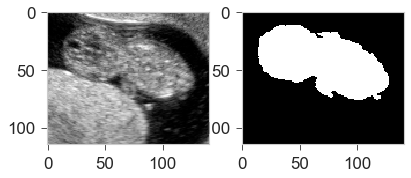

(224, 192)


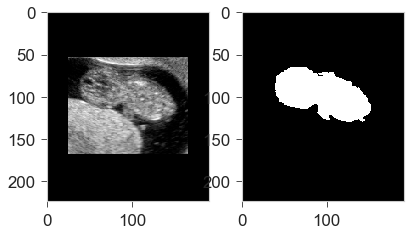

In [10]:
# check and show image shapes old to new
index = 70
print(inputdatasets['dataset1']['org'][0].shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(inputdatasets['dataset1']['org'][index], cmap='gray')
ax2.imshow(inputdatasets['dataset1']['gt'][index], cmap='gray')
plt.show()

print(inputdatasetspadded['dataset1']['org'][0].shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(inputdatasetspadded['dataset1']['org'][index], cmap='gray')
ax2.imshow(inputdatasetspadded['dataset1']['gt'][index], cmap='gray')
plt.show()

### Optional/extra: Make all images size 128x128 

In [11]:
import skimage
from skimage.transform import resize
from skimage import img_as_bool

output_shape = (128,128)

def resize_frames(images):
    """ Resize the original frames based on the output shape. """
    results = []
    for image in images:
        image = image.astype(np.uint8)
        result = skimage.transform.resize(image, output_shape)
        results.append(result)
    
    return np.array(results, dtype=np.float32)

def resize_masks(images): 
    """ Resize the mask frames based on the output shape. """
    results = []
    for image in images:
        image = image.astype(np.bool)
        result = img_as_bool(resize(image, output_shape))
        results.append(result)
    
    return np.array(results, dtype=np.bool)

def resize_images(inputdatasets):
    """ Reshape the 2D images to the desired shape. """
   
    # iterate over inputdataset dictionary 
    for key, images in inputdatasets.items(): 
        image_reshaped_frames =  resize_frames(images['org'])
        try: 
            if images['gt'][0] == None:
                image_reshaped_masks = None
        except: 
            image_reshaped_masks =  resize_masks(images['gt'])
       
        # save reshaped images 
        inputdatasets[key] = {'org': image_reshaped_frames, 'gt': image_reshaped_masks}

In [12]:
# copy dictionary datasets 
inputdatasets128 = inputdatasets.copy()

# remake the images from 3D to 2D slices
resize_images(inputdatasets128)


(115, 141)


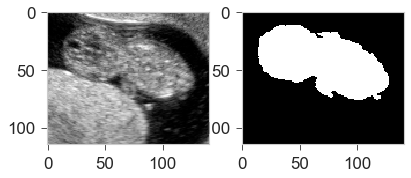

(128, 128)


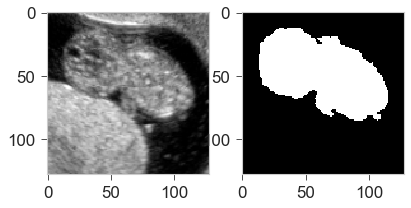

In [13]:
# check and show image shapes old to new
index = 70
print(inputdatasets['dataset1']['org'][0].shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(inputdatasets['dataset1']['org'][index], cmap='gray')
ax2.imshow(inputdatasets['dataset1']['gt'][index], cmap='gray')
plt.show()

print(inputdatasets128['dataset1']['org'][0].shape)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(inputdatasets128['dataset1']['org'][index], cmap='gray')
ax2.imshow(inputdatasets128['dataset1']['gt'][index], cmap='gray')
plt.show()


# Data preprocessing: make training and test datasets

In [14]:
# Fixed dataorder
def make_dataset(dataset, keylist, random_state):
    """ Make the dataset for either the trainingset or testset based on the keys of the datasets. """
    images_frames = []
    images_masks = []
    
    # make lists of frames and masks
    for key_index, images in dataset.items(): 
        if key_index in keylist: 
            for count, value in enumerate(images['org']):
                images_frames.append(value)
                try: 
                    images_masks.append(images['gt'][count])
                except: 
                    images_masks = None
    
    # shuffle the dataset
    try: 
        shuffling = list(zip(images_frames, images_masks))
        random.shuffle(shuffling)
        images_frames, images_masks = zip(*shuffling)
    except:
        random.shuffle(images_frames)
    
    return images_frames, images_masks


def check_groundtruth(dataset):
    """ Check the ground truth images and return the key datasets of dictionary. """
    keys_train = []
    keys_test = []
    
    for key, images in dataset.items(): 
        try: 
            if images['gt'] == None: 
                keys_test.append(key)
        except:
                keys_train.append(key)
        
    return keys_train, keys_test

def make_fixed_training_testset(dataset, test_size=0.30, random_state=42):
    """ This dataorder checks whether an dataset contains a ground truth. 
        When it does not, the dataset becomes a testset, when it does, the dataset becomes a trainingset. """
    
    # dataset keys for either training or testset
    keys_train, keys_test = check_groundtruth(dataset)
    
    # based on keys, generate training and test datasets
    train_frames, train_masks = make_dataset(dataset, keys_train, random_state)
    test_frames, test_masks = make_dataset(dataset, keys_test, random_state)
    
    print('Training datasets:', keys_train, 'contain', str(len(train_frames)), 'images')
    print('Testing datasets: ', keys_test, 'contain', str(len(test_frames)), 'images')
    print('Total images: ', str(len(train_frames) + len(test_frames)))
    metadata = {'Training datasets' : keys_training, 'Testing datasets' : keys_testing}
  
    return np.array(train_frames), np.array(test_frames), np.array(train_masks), np.array(test_masks), metadata
    

In [15]:
# Ordered dataorder
def define_datasizes(dataset, test_size): 
    """ Define the number of datasets used in the training and test dataset. """
    
    total_length = len(dataset) 
    nr_testing = round(total_length * test_size)
    nr_training = total_length - nr_testing 
    
    return nr_training, nr_testing

def make_ordered_training_testset(dataset, test_size, random_state):
    """ This dataorder randomly puts a whole dataset in the training or testset. """
    
    # define random state 
    random.seed(random_state)
    
    # define percentage of number of datasets used in training and testing 
    # and use this to generate the keys of training and testing datasets
    nr_training, nr_testing = define_datasizes(dataset, test_size)
    
    all_keys = list(dataset.keys())
    keys_training = random.sample(all_keys, nr_training)
    keys_testing = list(set(all_keys).symmetric_difference(keys_training))
    
    # based on keys, generate training and test datasets
    train_frames = []
    test_frames = []
    train_masks = []
    test_masks = []
    
    for key, images in dataset.items(): 
        # training images 
        if key in keys_training: 
            for count, value in enumerate(images['org']):
                train_frames.append(value)
                train_masks.append(images['gt'][count])
        
        # testing images 
        if key in keys_testing: 
            for count, value in enumerate(images['org']):
                test_frames.append(value)
                test_masks.append(images['gt'][count])
                
    # shuffle all images inside the frame lists 
    shuffle_train = list(zip(train_frames, train_masks))
    random.shuffle(shuffle_train)
    train_frames, train_masks = zip(*shuffle_train)
    
    shuffle_test = list(zip(test_frames, test_masks))
    random.shuffle(shuffle_test)
    test_frames, test_masks = zip(*shuffle_test)
        
    
    print('Training datasets:' , keys_training, 'contain', str(len(train_frames)), 'images')
    print('Testing datasets:', keys_testing, 'contain', str(len(test_frames)), 'images')
    print('Total images: ', str(len(train_frames) + len(test_frames)))
    metadata = {'Training datasets' : keys_training, 'Testing datasets' : keys_testing}
    
    return np.array(train_frames), np.array(test_frames), np.array(train_masks), np.array(test_masks), metadata

In [16]:
# Mixed dataorder
from sklearn.model_selection import train_test_split

def all_images(dataset):
    """ Return all the 2D slices. """
    images_frames = []
    images_masks = []
    
    # get all the 2D slices
    for key, images in dataset.items(): 
        for count, value in enumerate(images['org']):
            images_frames.append(images['org'][count])
            images_masks.append(images['gt'][count])
                
    return images_frames, images_masks
    
def make_mixed_training_testset(dataset, test_size=0.20, random_state=42):
    """ This dataorder takes all the images of all datasets and mixes these images 
    to put them either in the training or testset. """
    
    # Get all the images 
    all_frames, all_masks = all_images(dataset)

    # Split the images in a train and test dataset
    train_frames, test_frames, train_masks, test_masks = train_test_split(all_frames, all_masks, 
                                                                          test_size=test_size,random_state=random_state)
    
    print('Training dataset contain', str(len(train_frames)), 'images')
    print('Testing dataset contain', str(len(test_frames)), 'images')
    print('Total images: ', str(len(train_frames) + len(test_frames)))
    metadata = 'no metadata' #Training datasets' : keys_training, 'Testing datasets' : keys_testing}
    
    return np.array(train_frames), np.array(test_frames), np.array(train_masks), np.array(test_masks), metadata

In [17]:
def create_traintestframes(inputdataset, dataorder='ordered', test_size=0.30, random_state=42):
    """ Dependent on the dataorder, create the train and test frames. """
    print('Dataorder: ', dataorder)

    if dataorder == 'fixed':
        # The datasets with ground truth become training images, the datasets with no ground truth the test images. 
        # The train and test images are shuffled. 
        train_frames, test_frames, train_masks, test_masks, metadata = make_fixed_training_testset(inputdataset,
                                                                                                   test_size=0.30, random_state=random_state)

    if dataorder == 'ordered':
        # The images of each dataset are kept in the same dataset (either training or testing)
        train_frames, test_frames, train_masks, test_masks, metadata = make_ordered_training_testset(inputdataset, 
                                                                                                     test_size=0.30, random_state=random_state)

    if dataorder == 'mixed':
        # The images of each dataset are mixed (combined in training and testing)
        train_frames, test_frames, train_masks, test_masks, metadata = make_mixed_training_testset(inputdataset, 
                                                                                                   test_size=0.30, random_state=random_state)
    
    return train_frames, test_frames, train_masks, test_masks, metadata
    
    

In [18]:
# example 
train_frames, test_frames, train_masks, test_masks, metadata = create_traintestframes(inputdatasetspadded, dataorder='ordered', test_size=0.30, random_state=42)

Dataorder:  ordered
Training datasets: ['dataset6', 'dataset1', 'dataset7', 'dataset3', 'dataset5'] contain 2303 images
Testing datasets: ['dataset4', 'dataset2'] contain 735 images
Total images:  3038


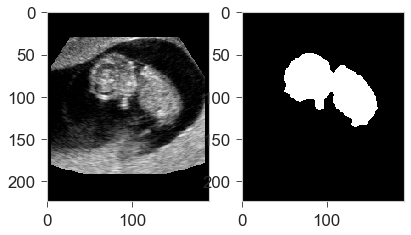

['dataset6', 'dataset1', 'dataset7', 'dataset3', 'dataset5']

In [19]:
# check
index = 100
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(train_frames[index], cmap='gray')
ax2.imshow(train_masks[index], cmap='gray')
plt.show()

metadata['Training datasets']

# Data generator: generate operable data for U-net

In [20]:
def reshape_data(data): 
    """ Reshaping the data to (x, y, z, 1). """
    data = np.reshape(data, (data.shape[0], data.shape[1], data.shape[2], 1))
    return data

def generator(images_frames, images_masks):   
    """ Generate operable data for Unet. """
    results_frames = reshape_data(images_frames)
    try:
        results_masks = reshape_data(images_masks)
    except: 
        results_masks = None

    return results_frames, results_masks


In [21]:
# example
X_train, Y_train = generator(train_frames, train_masks)
X_test, Y_test = generator(test_frames, test_masks)

print('Training data shape : ', X_train.shape, Y_train.shape)
print('Testing data shape : ', X_test.shape) #, Y_test.shape)

Training data shape :  (2303, 224, 192, 1) (2303, 224, 192, 1)
Testing data shape :  (735, 224, 192, 1)


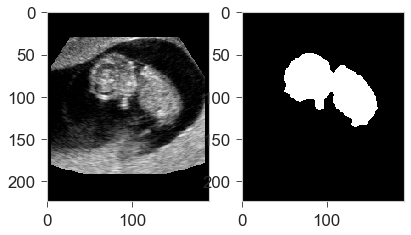

In [22]:
# check
index = 100
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(np.squeeze(X_train[index]), cmap='gray')
ax2.imshow(np.squeeze(Y_train[index]), cmap='gray')
plt.show()

# The model

### Import the dependencies

In [2]:
# https://medium.com/@pallawi.ds/semantic-segmentation-with-u-net-train-and-test-on-your-custom-data-in-keras-39e4f972ec89
import os
import sys
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

In [24]:
# Dependencies
IMG_WIDTH = img_width
IMG_HEIGHT = img_height
IMG_CHANNELS = 1 #grayscale image (otherwise 3 for RGB image)

# example
print('The train images and masks: ')
print("X_train",X_train.shape)
print("Y_train",Y_train.shape)
print("X_test",X_test.shape)
print("Y_test",Y_test.shape)

The train images and masks: 
X_train (2303, 224, 192, 1)
Y_train (2303, 224, 192, 1)
X_test (735, 224, 192, 1)
Y_test (735, 224, 192, 1)


c:\users\rmmee\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


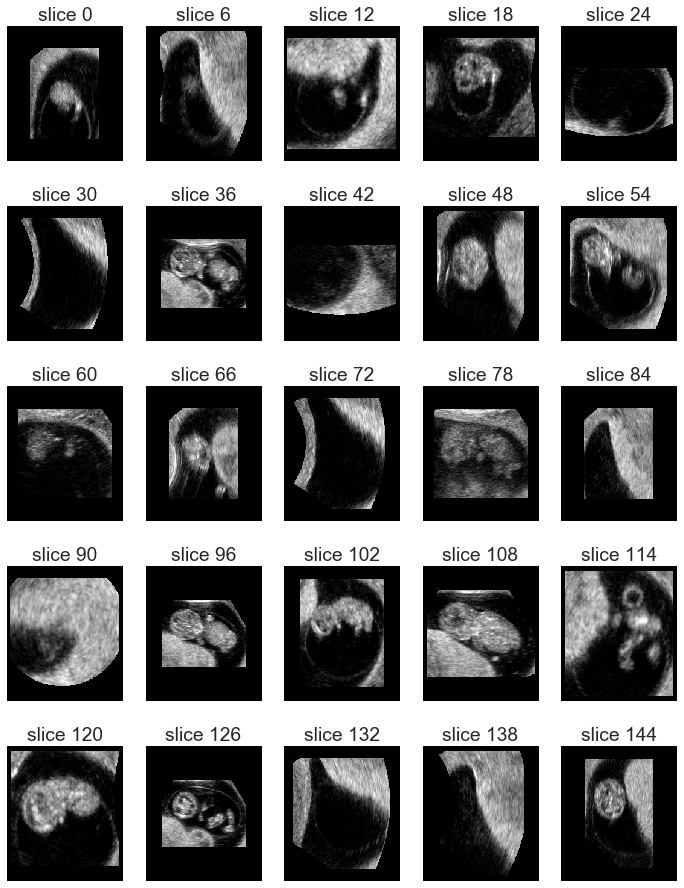

In [25]:
def sample_stack(stack, rows=8, cols=5, steps=4):
    """ Show sample slices of the stacked images. """
    fig,ax = plt.subplots(rows,cols,figsize=[12,16])
    
    show_slice = []
    for i in range(0,len(imgs_to_process), steps):
        show_slice.append(i)
    
    show_index = 0
    for i in range(rows*cols):
        if show_index == len(show_slice):
            show_index = 0         
   
        x = show_slice[show_index]
        ax[int(i/cols),int(i % cols)].set_title('slice %d' % x)
        ax[int(i/cols),int(i % cols)].imshow(stack[x], cmap='gray')
        ax[int(i/cols),int(i % cols)].axis('off')
        show_index += 1
                
    plt.show()       

imgs_to_process = np.squeeze(X_train)
sample_stack(imgs_to_process, rows=5, cols=5, steps=6)

### The metrics

In [3]:
from sklearn.metrics.pairwise import pairwise_distances

# https://drive.google.com/drive/folders/1HfUdaMsfmTpmmWHz4OlxtPcc0Sk7moEV
def mean_iou(y_true, y_pred):
    """ Mean Intersection over Union (IoU). """
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred > t)
        score, up_opt = tf.metrics.mean_iou(y_true, y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

# https://www.kaggle.com/c/ultrasound-nerve-segmentation/discussion/21358
def dice_coef(y_true, y_pred):
    """ Dice similarity coefficient. """
    smooth = 1.0
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    intersection = 2. * K.sum(y_true_f * y_pred_f, axis=1, keepdims=True) + smooth
    union = K.sum(y_true_f, axis=1, keepdims=True) + K.sum(y_pred_f, axis=1, keepdims=True) + smooth
    return K.mean(intersection / union)

# https://datascience.stackexchange.com/questions/45165/how-to-get-accuracy-f1-precision-and-recall-for-a-keras-model
def recall_m(y_true, y_pred):
    """ Recall. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    """ Precision. """
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# https://github.com/zhengyang-wang/3D-Unet--Tensorflow/blob/master/utils/HausdorffDistance.py
def hausdorff_distance(y_true, y_pred):
    """ Hausdorff distance. """
    y_true_f = K.batch_flatten(y_true)
    y_pred_f = K.batch_flatten(y_pred)
    d2matrix = pairwise_distances(y_true_f, y_pred_f, metric='euclidean')
    hd = tf.math.reduce_mean(tf.math.minimum(d2matrix, axis=0)) + tf.math.reduce_mean(tf.math.minimum(d2matrix, axis=1)) 
    return hd


In [28]:
import time
import keras 

class TimeHistory(keras.callbacks.Callback):
    """ Time the history of the run. """
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, epoch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, epoch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

### The U-net

In [29]:
def U_net():
    """ Build U-Net model. """
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = Lambda(lambda x: x / 255) (inputs)

    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (s)
    c1 = Dropout(0.1) (c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c1)
    p1 = MaxPooling2D((2, 2)) (c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p1)
    c2 = Dropout(0.1) (c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c2)
    p2 = MaxPooling2D((2, 2)) (c2)

    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p2)
    c3 = Dropout(0.2) (c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c3)
    p3 = MaxPooling2D((2, 2)) (c3)

    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p3)
    c4 = Dropout(0.2) (c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c4)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (p4)
    c5 = Dropout(0.3) (c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c5)

    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same') (c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u6)
    c6 = Dropout(0.2) (c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c6)

    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u7)
    c7 = Dropout(0.2) (c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c7)

    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u8)
    c8 = Dropout(0.1) (c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c8)

    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (u9)
    c9 = Dropout(0.1) (c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same') (c9)

    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    model.compile(optimizer='adam', 
                  loss='binary_crossentropy', 
                  metrics=['accuracy', dice_coef, mean_iou, recall_m, precision_m])
    model.summary()
    return model

# Model training

In [30]:
def save_data_pickle(PATH, data, filename):
    """ Save data in pickle file. """
    with open(PATH + '/' + filename + ".pkl","wb") as f:
        pickle.dump(data,f)
    print(filename, "created")
    

In [31]:
# Train the model
epoch = 30
# dataorder = 'ordered'
modelname = 'experimentmodel_unet_relu_org'
input_datasets = inputdatasetspadded


# def train_model(modelnumber, dataorder, random_state):
def train_model(batchsize, dataorder, name, random_state):
    """ Train the model. """
    # Fit model
    earlystopper = EarlyStopping(patience=10, verbose=1)
    
    # save the frames, metadata, and metric results 
    unetdata = {} 
    
    filename = modelname + str(name)
    print('run: ' + filename)
    
    # create train and test frames
    train_frames, test_frames, train_masks, test_masks, metadata = create_traintestframes(input_datasets, 
                                                                                          dataorder = dataorder, 
                                                                                          test_size=0.30, 
                                                                                          random_state=random_state)

    # split into 80% for train and 20% for validation
    # with a random state different than the previous one to make sure the data is from different datasets
    train_frames, val_frames, train_masks, val_masks = train_test_split(train_frames, train_masks, 
                                                                        test_size=0.20, random_state=int(random_state+1))
    
    # (save) the data frames
    X_train, Y_train = generator(train_frames, train_masks)
    X_val, Y_val = generator(val_frames, val_masks)
    X_test, Y_test = generator(test_frames, test_masks)
    data_frames = {'X_train': X_train, 'Y_train': Y_train,
                   'X_val': X_val, 'Y_val': Y_val, 
                   'X_test': X_test, 'Y_test': Y_test}
    
    # run the model 
    model = U_net()
    checkpoint_path = os.path.join(RESULTS_MODEL_PATH, filename)
    checkpointer = ModelCheckpoint(filepath=checkpoint_path, verbose=1, save_best_only=True)
    time_callback = TimeHistory()
    results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), batch_size=batchsize, epochs=epoch, 
                        callbacks=[earlystopper, checkpointer, time_callback])
    
    # save time and best value
    best = checkpointer.best
    timings = time_callback.times
    
    # save the metrics
    loss_train = results.history['loss']
    loss_val = results.history['val_loss']
    
    acc_train = results.history['acc']
    acc_val = results.history['val_acc']
    
    dice_train = results.history['dice_coef']
    dice_val = results.history['val_dice_coef']
    
    mean_iou_train = results.history['mean_iou']
    mean_iou_val = results.history['val_mean_iou']
    
    precision_train = results.history['precision_m']
    precision_val = results.history['val_precision_m']
    
    recall_train = results.history['recall_m']
    recall_val = results.history['val_recall_m']
    
    
    unetdata.update({'dataframes': data_frames, 'metadata': metadata,
                     'best': best, 'timings': timings, 
                     'loss_train': loss_train, 'loss_val':loss_val,
                     'acc_train': acc_train, 'acc_val': acc_val,
                     'dice_train': dice_train, 'dice_val': dice_val,                     
                     'mean_iou_train': mean_iou_train, 'mean_iou_val': mean_iou_val,
                     'precision_train': precision_train, 'precision_val': precision_val,
                     'recall_train': recall_train, 'recall_val': recall_val})
    
    # save from the model the data in pickle
    save_data_pickle(PATH = RESULTS_DATA_PATH, data=unetdata, filename=filename)
    print('U-net finished')
    
    # save the model 
    name = 'results_' + modelname + str(name)
    modelpath = os.path.join(RESULTS_MODEL_PATH, name)
    model.save(modelpath)
    
    return results

    
# train_model(batchsize=16, dataorder = 'ordered', name = '16', random_state=42)
# train_model(batchsize=32, dataorder = 'ordered', name = '32', random_state=42)
# train_model(batchsize=64, dataorder = 'ordered', name = '64', random_state=42)
# train_model(batchsize=128, dataorder = 'ordered', name = '128', random_state=42)
# train_model(batchsize=128, dataorder = 'ordered', name = '128_2', random_state=42)


run: experimentmodel_unet_relu_org128_2
Dataorder:  ordered
Training datasets: ['dataset6', 'dataset1', 'dataset7', 'dataset3', 'dataset5'] contain 2303 images
Testing datasets: ['dataset4', 'dataset2'] contain 735 images
Total images:  3038
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 192, 1)  0                                            
____________________________________________________

Train on 1842 samples, validate on 461 samples
Epoch 1/30
1842/1842 [==============================] - 630s 342ms/step - loss: 0.5991 - acc: 0.9338 - dice_coef: 0.0306 - mean_iou: 0.4404 - recall_m: 0.0035 - precision_m: 0.0236 - val_loss: 0.4068 - val_acc: 0.9501 - val_dice_coef: 0.0644 - val_mean_iou: 0.4732 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00

Epoch 00001: val_loss improved from inf to 0.40676, saving model to results_unet_experiment\results_unet_model\experimentmodel_unet_relu_org128_2
Epoch 2/30
1842/1842 [==============================] - 570s 309ms/step - loss: 0.1710 - acc: 0.9469 - dice_coef: 0.1344 - mean_iou: 0.4735 - recall_m: 5.0126e-07 - precision_m: 0.0029 - val_loss: 0.1336 - val_acc: 0.9501 - val_dice_coef: 0.1875 - val_mean_iou: 0.4735 - val_recall_m: 0.0000e+00 - val_precision_m: 0.0000e+00

Epoch 00002: val_loss improved from 0.40676 to 0.13357, saving model to results_unet_experiment\results_unet_model\experimentmodel_unet_relu_org128_2
Epoch 3

### Show training results

In [5]:
# open pickle 
def load_data_pickle(PATH, filename):
    """ Load data from file using pickle. """
    with open(PATH + '/' + filename + ".pkl","rb") as f:
        new_data = pickle.load(f)

    print(filename, "opened")
    return new_data

In [6]:
# open the model results
modelnumbers = [16, 32, 64, 1282]
modelname = 'experimentmodel_unet_relu_org'
epochs = 30
modelresults = {}

for modelnumber in modelnumbers: 
    filename = modelname + str(modelnumber)
    modelresult = load_data_pickle(PATH= RESULTS_DATA_PATH, filename=filename)
    modelresults[filename] = modelresult


experimentmodel_unet_relu_org16 opened
experimentmodel_unet_relu_org32 opened
experimentmodel_unet_relu_org64 opened
experimentmodel_unet_relu_org1282 opened


In [7]:
# make lists to plot results
timings = []
loss_train = []
loss_val = []
dice_train = []
dice_val = []
iou_train = []
iou_val = []
acc_train = []
acc_val = []
precision_train = []
precision_val = []
recall_train = []
recall_val = []

for key,value in modelresults.items():
    timings.append(value['timings'])
    loss_train.append(value['loss_train'])
    loss_val.append(value['loss_val'])
    dice_train.append(value['dice_train'])
    dice_val.append(value['dice_val'])
    iou_train.append(value['mean_iou_train'])
    iou_val.append(value['mean_iou_val'])
    acc_train.append(value['acc_train'])
    acc_val.append(value['acc_val'])
    precision_train.append(value['precision_train'])
    precision_val.append(value['precision_val'])
    recall_train.append(value['recall_train'])
    recall_val.append(value['recall_val'])


In [8]:
def calc_meanstd(listing):
    """ Calculate the mean and standard deviation. """
    
    # make all lists as long as the number of epochs
    for lis in listing: 
        while len(lis) != epochs: 
            lis.insert(len(lis),lis[-1])
   
    # transpose list and compute mean and std
    new_list = list(map(list, zip(*listing)))
    
    results_mean = []
    results_std = []
    for i in new_list: 
        results_mean.append(np.mean(i))
        results_std.append(np.std(i))
    
    return np.array(results_mean), np.array(results_std)


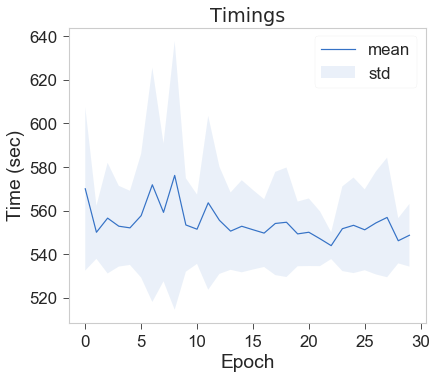

554.5530242900054

In [12]:
# Plot the results of how long the simulations took
means, stds = calc_meanstd(timings)

plt.plot(means)
plt.fill_between(range(len(means)),means-stds,means+stds,alpha=.1)
plt.title('Timings', fontname="DejaVu Sans")
plt.xlabel('Epoch')
plt.ylabel('Time (sec)')
plt.legend(['mean', 'std'], loc='best')
plt.tight_layout()
plt.savefig(RESULTS_VIS_PATH + '/' + 'exp_unet_relu_org_timings.png')
plt.show()

np.mean(means)

In [25]:
def plot_results(data_train, filename, titlename, ylabel, names, xlim=None, ylim=None, location=None):
    """ Plot the results of the metrics during training. """
    
    count = 0
    for index, x in enumerate(data_train): 
        count +=1
        plt.plot(x, label='batch size = ' + str(names[index]))
    
    plt.title(titlename, fontname="DejaVu Sans")
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.xticks(np.linspace(0,epochs,int(epochs/5+1)))
    
    try: 
        plt.xlim(xlim[0], xlim[1])
    except:
        pass
    
    try: 
        plt.ylim(ylim[0], ylim[1])
    except:
        pass
        
    try: 
        plt.legend(loc=location)
    except: 
        plt.legend(loc='best')
    
    plt.tight_layout()
    plt.savefig(RESULTS_VIS_PATH + '/' + 'exp_unet_relu_org_loss.png')
    plt.show()
    

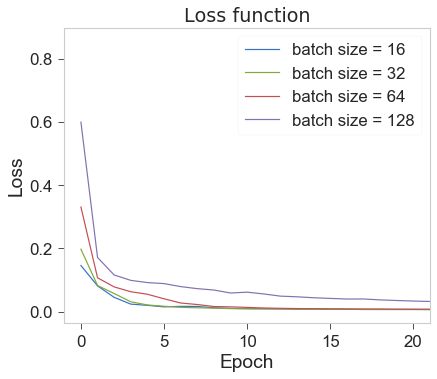

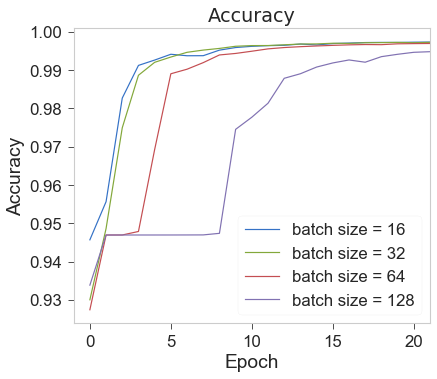

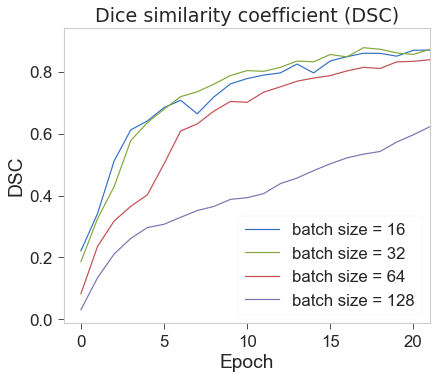

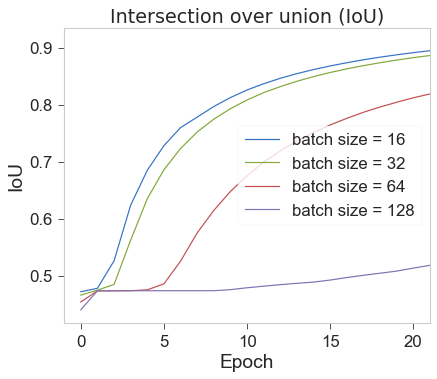

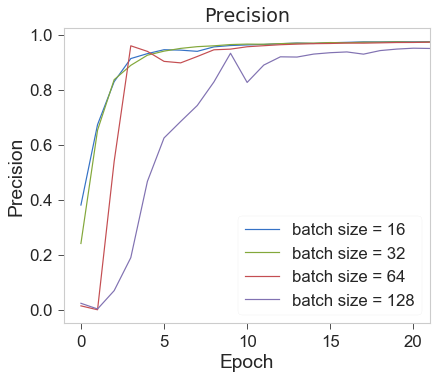

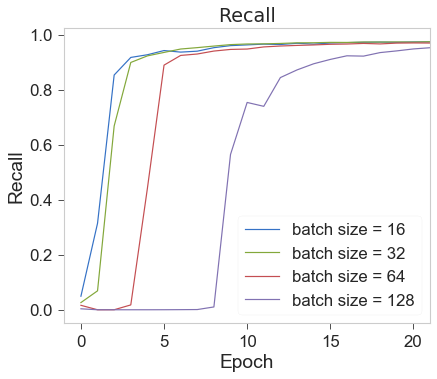

In [33]:
plot_results(loss_train, filename='exp_unet_relu_org_loss', titlename='Loss function', ylabel='Loss', names=[16,32,64,128], xlim=[-1, 21])
plot_results(acc_train, filename='exp_unet_relu_org_acc', titlename='Accuracy', ylabel='Accuracy', names=[16,32,64,128], xlim=[-1, 21])
plot_results(dice_train, filename='exp_unet_relu_org_dice', titlename='Dice similarity coefficient (DSC)', ylabel='DSC', names=[16,32,64,128], xlim=[-1, 21])
plot_results(iou_train, filename='exp_unet_relu_org_iou', titlename='Intersection over union (IoU)', ylabel='IoU', names=[16,32,64,128], xlim=[-1, 21])
plot_results(precision_train, filename='exp_unet_relu_org_precision', titlename='Precision', ylabel='Precision', names=[16,32,64,128], xlim=[-1, 21])
plot_results(recall_train, filename='exp_unet_relu_org_recall', titlename='Recall', ylabel='Recall', names=[16,32,64,128], xlim=[-1, 21])
